In [1]:
import cv2
import os
import numpy as np
import random
from matplotlib import pyplot as plt

In [2]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [4]:
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [5]:
import uuid

In [6]:
os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))

'data\\anchor\\9321e069-cae8-11ec-883f-9cfce8b138fb.jpg'

In [7]:
cap = cv2.VideoCapture(0)
while cap.isOpened(): 
    ret, frame = cap.read()
    
       # Cut down frame to 250x250px
    frame = frame[120:120+250,200:200+250, :]
    
     # Collect anchor
    if cv2.waitKey(1) & 0XFF == ord('a'):
        # Create the unique file path 
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out anchor image
        cv2.imwrite(imgname, frame)
    # Collect positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
        # Create the unique file path 
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out positive image
        cv2.imwrite(imgname, frame)
    
    cv2.imshow('Image Collection', frame)
    
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break

# Release the webcam
cap.release()
# Close the image show frame
cv2.destroyAllWindows() 


In [8]:
def data_aug(img):
    data = []
    for i in range(9):
        img = tf.image.stateless_random_brightness(img, max_delta=0.02, seed=(1,2))
        img = tf.image.stateless_random_contrast(img, lower=0.6, upper=1, seed=(1,3))
        # img = tf.image.stateless_random_crop(img, size=(20,20,3), seed=(1,2))
        img = tf.image.stateless_random_flip_left_right(img, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_jpeg_quality(img, min_jpeg_quality=90, max_jpeg_quality=100, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_saturation(img, lower=0.9,upper=1, seed=(np.random.randint(100),np.random.randint(100)))
            
        data.append(img)
    
    return data

In [9]:
import os
import uuid

In [10]:
img_path = os.path.join(ANC_PATH, '9321e069-cae8-11ec-883f-9cfce8b138fb.jpg')
img = cv2.imread(img_path)
augmented_images = data_aug(img)

for image in augmented_images:
    cv2.imwrite(os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1())), image.numpy(

SyntaxError: unexpected EOF while parsing (<ipython-input-10-6d742e6026c8>, line 6)

In [12]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(200)
positive = tf.data.Dataset.list_files(POS_PATH+'\*.jpg').take(200)
negative = tf.data.Dataset.list_files(NEG_PATH+'\*.jpg').take(200)

In [13]:
dir_test = anchor.as_numpy_iterator()

In [14]:
print(dir_test.next())

b'data\\anchor\\97a34eb2-ca32-11ec-b62c-9cfce8b138fb.jpg'


In [15]:
def preprocess(file_path):
    
    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image 
    img = tf.io.decode_jpeg(byte_img)
    
    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (100,100))
    # Scale image to be between 0 and 1 
    img = img / 255.0

    # Return image
    return img

In [16]:
img = preprocess(b'data\\anchor\\dc9b500c-ca32-11ec-ad69-9cfce8b138fb.jpg')

In [17]:
img.numpy().min()

0.03529412

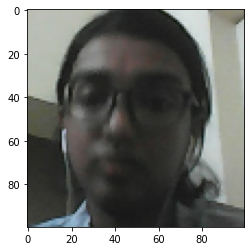

In [18]:
plt.imshow(img)

In [19]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [20]:
samples = data.as_numpy_iterator()

In [21]:
example = samples.next()

In [22]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [23]:
res = preprocess_twin(*example)

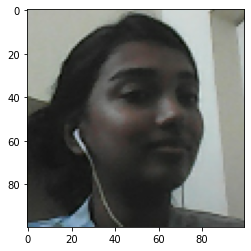

In [24]:
plt.imshow(res[1])

In [25]:
res[2]

1.0

In [26]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=10000)

In [27]:
samples = data.as_numpy_iterator()


In [28]:
# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [29]:
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

In [30]:
inp = Input(shape=(100,100,3), name='input_image')

In [31]:
c1 = Conv2D(64, (10,10), activation='relu')(inp)

In [32]:
m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

In [33]:
c2 = Conv2D(128, (7,7), activation='relu')(m1)
m2 = MaxPooling2D(64, (2,2), padding='same')(c2)

In [34]:
c3 = Conv2D(128, (4,4), activation='relu')(m2)
m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

In [35]:
c4 = Conv2D(256, (4,4), activation='relu')(m3)
f1 = Flatten()(c4)
d1 = Dense(4096, activation='sigmoid')(f1)

In [36]:
mod = Model(inputs=[inp], outputs=[d1], name='embedding')

In [37]:
mod.summary()

Model: "embedding"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_image (InputLayer)     [(None, 100, 100, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 91, 91, 64)        19264     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 46, 46, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 40, 40, 128)       401536    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 20, 20, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 17, 17, 128)       262272    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 9, 9, 128)         0 

In [38]:
def make_embedding(): 
    inp = Input(shape=(100,100,3), name='input_image')
    
    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # Third block 
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [39]:
embedding = make_embedding()

In [40]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_image (InputLayer)     [(None, 100, 100, 3)]     0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 91, 91, 64)        19264     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 46, 46, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 40, 40, 128)       401536    
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 20, 20, 128)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 17, 17, 128)       262272    
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 9, 9, 128)         0 

In [41]:
# Siamese L1 Distance class
class L1Dist(Layer):
    
    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()
       
    # Magic happens here - similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [42]:
input_image = Input(name='input_img', shape=(100,100,3))
validation_image = Input(name='validation_img', shape=(100,100,3))

In [43]:
inp_embedding = embedding(input_image)
val_embedding = embedding(validation_image)

In [44]:
siamese_layer = L1Dist()

In [45]:
distances = siamese_layer(inp_embedding, val_embedding)

In [46]:
classifier = Dense(1, activation='sigmoid')(distances)

In [47]:
siamese_network = Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [48]:
siamese_network.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_img (InputLayer)          [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
validation_img (InputLayer)     [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
embedding (Functional)          (None, 4096)         38960448    input_img[0][0]                  
                                                                 validation_img[0][0]             
__________________________________________________________________________________________________
l1_dist (L1Dist)                (None, 4096)         0           embedding[0][0]     

In [49]:
def make_siamese_model(): 
    
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))
    
    # Validation image in the network 
    validation_image = Input(name='validation_img', shape=(100,100,3))
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [50]:
siamese_model = make_siamese_model()

In [51]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_img (InputLayer)          [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
validation_img (InputLayer)     [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
embedding (Functional)          (None, 4096)         38960448    input_img[0][0]                  
                                                                 validation_img[0][0]             
__________________________________________________________________________________________________
distance (L1Dist)               (None, 4096)         0           embedding[2][0]     

In [52]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [53]:
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001

In [54]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)


In [55]:
test_batch = train_data.as_numpy_iterator()

In [56]:
batch_1 = test_batch.next()

In [57]:
X = batch_1[:2]

In [58]:
y = batch_1[2]

In [59]:
@tf.function
def train_step(batch):
    
    # Record all of our operations 
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
        
    # Return loss
    return loss

In [60]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

In [61]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Creating a metric object 
        r = Recall()
        p = Precision()
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            train_step(batch)
            progbar.update(idx+1)
        # Save checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

In [62]:
EPOCHS = 10

In [63]:
train(train_data, EPOCHS)



 Epoch 1/10
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
18/18 [==============================] - 425s 24s/step

 Epoch 2/10
18/18 [==============================] - 441s 24s/step

 Epoch 3/10
18/18 [==============================] - 445s 25s/step

 Epoch 4/10
18/18 [==============================] - 442s 24s/step

 Epoch 5/10
18/18 [==============================] - 441s 24s/step

 Epoch 6/10
18/18 [==============================] - 446s 25s/step

 Epoch 7/10
18/18 [==============================] - 535s 30s/step

 Epoch 8/10
18/18 [==============================] - 437s 24s/step

 Epoch 9/10
18/18 [==============================] - 430s 24s/step

 Epoch 10/10
18/18 [==============================] - 434s 24s/step


In [64]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

In [65]:
# Get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [66]:
y_hat = siamese_model.predict([test_input, test_val])

In [67]:
# Post processing the results 
[1 if prediction > 0.5 else 0 for prediction in y_hat ]

[0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1]

In [68]:
y_true

array([0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 1., 1., 0., 1., 1.],
      dtype=float32)

In [69]:
# Creating a metric object 
m = Recall()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [70]:
# Creating a metric object 
m = Precision()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [71]:
r = Recall()
p = Precision()

for test_input, test_val, y_true in test_data.as_numpy_iterator():
    yhat = siamese_model.predict([test_input, test_val])
    r.update_state(y_true, yhat)
    p.update_state(y_true,yhat) 

print(r.result().numpy(), p.result().numpy())

1.0 1.0


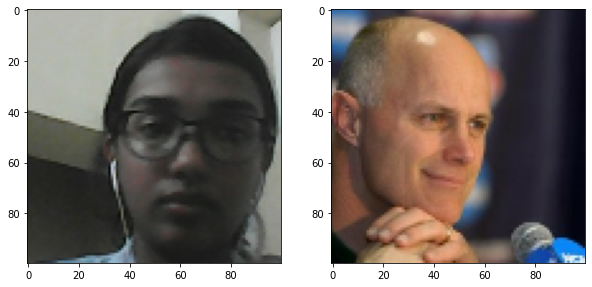

In [72]:
# Set plot size 
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[0])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[0])

# Renders cleanly
plt.show()

# Save Model

In [73]:
# Save weights
siamese_model.save('siamesemodelv2.h5')

In [74]:
L1Dist

__main__.L1Dist

In [75]:
# Reload model 
siamese_model = tf.keras.models.load_model('siamesemodelv2.h5', 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [76]:
# Make predictions with reloaded model
siamese_model.predict([test_input, test_val])

array([[3.8487819e-05],
       [2.1866262e-03],
       [3.5049617e-03],
       [2.5328994e-04],
       [5.2754014e-05],
       [9.9999595e-01],
       [9.9998844e-01],
       [1.2993813e-04]], dtype=float32)

In [77]:
# View model summary
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_img (InputLayer)          [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
validation_img (InputLayer)     [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
embedding (Functional)          (None, 4096)         38960448    input_img[0][0]                  
                                                                 validation_img[0][0]             
__________________________________________________________________________________________________
l1_dist_2 (L1Dist)              (None, 4096)         0           embedding[0][0]     

In [79]:
## Real Time Test

In [80]:
application_data\verification_images

SyntaxError: unexpected character after line continuation character (<ipython-input-80-10b5f818160f>, line 1)

In [81]:
os.listdir(os.path.join('application_data', 'verification_images'))

['000bc1bd-ca33-11ec-aad5-9cfce8b138fb.jpg',
 '00c1dd5d-ca33-11ec-96ec-9cfce8b138fb.jpg',
 '00ea687e-ca33-11ec-984f-9cfce8b138fb.jpg',
 '01b8376a-ca33-11ec-9a90-9cfce8b138fb.jpg',
 '01c60560-ca33-11ec-b503-9cfce8b138fb.jpg',
 '01d44de5-ca33-11ec-b583-9cfce8b138fb.jpg',
 '01eb8e21-ca33-11ec-8898-9cfce8b138fb.jpg',
 '01f9b711-ca33-11ec-9f50-9cfce8b138fb.jpg',
 '02ac11c6-ca33-11ec-ba61-9cfce8b138fb.jpg',
 '02bc9720-ca33-11ec-8861-9cfce8b138fb.jpg',
 '02cae44c-ca33-11ec-9edf-9cfce8b138fb.jpg',
 '02d8e4a7-ca33-11ec-a292-9cfce8b138fb.jpg',
 '02e6ef14-ca33-11ec-b809-9cfce8b138fb.jpg',
 '03a14855-ca33-11ec-a682-9cfce8b138fb.jpg',
 '03b8efc5-ca33-11ec-a2ec-9cfce8b138fb.jpg',
 '03c750c5-ca33-11ec-b5f9-9cfce8b138fb.jpg',
 '03d3232e-ca33-11ec-8546-9cfce8b138fb.jpg',
 '03e14617-ca33-11ec-9f3c-9cfce8b138fb.jpg',
 '03efd6f4-ca33-11ec-8b3f-9cfce8b138fb.jpg',
 '03fdde8e-ca33-11ec-bb21-9cfce8b138fb.jpg',
 '3a1ffcbc-ca33-11ec-9f27-9cfce8b138fb.jpg',
 '3a270230-ca33-11ec-96aa-9cfce8b138fb.jpg',
 '3a3a5817

In [82]:
os.path.join('application_data', 'input_image', 'input_image.jpg')

'application_data\\input_image\\input_image.jpg'

In [83]:
for image in os.listdir(os.path.join('application_data', 'verification_images')):
    validation_img = os.path.join('application_data', 'verification_images', image)
    print(validation_img)

application_data\verification_images\000bc1bd-ca33-11ec-aad5-9cfce8b138fb.jpg
application_data\verification_images\00c1dd5d-ca33-11ec-96ec-9cfce8b138fb.jpg
application_data\verification_images\00ea687e-ca33-11ec-984f-9cfce8b138fb.jpg
application_data\verification_images\01b8376a-ca33-11ec-9a90-9cfce8b138fb.jpg
application_data\verification_images\01c60560-ca33-11ec-b503-9cfce8b138fb.jpg
application_data\verification_images\01d44de5-ca33-11ec-b583-9cfce8b138fb.jpg
application_data\verification_images\01eb8e21-ca33-11ec-8898-9cfce8b138fb.jpg
application_data\verification_images\01f9b711-ca33-11ec-9f50-9cfce8b138fb.jpg
application_data\verification_images\02ac11c6-ca33-11ec-ba61-9cfce8b138fb.jpg
application_data\verification_images\02bc9720-ca33-11ec-8861-9cfce8b138fb.jpg
application_data\verification_images\02cae44c-ca33-11ec-9edf-9cfce8b138fb.jpg
application_data\verification_images\02d8e4a7-ca33-11ec-a292-9cfce8b138fb.jpg
application_data\verification_images\02e6ef14-ca33-11ec-b809-9cf

In [84]:
def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))
        
        # Make Predictions 
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    # Detection Threshold: Metric above which a prediciton is considered positive 
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification Threshold: Proportion of positive predictions / total positive samples 
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images'))) 
    verified = verification > verification_threshold
    
    return results, verified

In [87]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250,200:200+250, :]
    
    cv2.imshow('Verification', frame)
    
    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        # Save input image to application_data/input_image folder 
#         hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
#         h, s, v = cv2.split(hsv)

#         lim = 255 - 10
#         v[v > lim] = 255
#         v[v <= lim] -= 10
        
#         final_hsv = cv2.merge((h, s, v))
#         img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)

        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        # Run verification
        results, verified = verify(siamese_model, 0.9, 0.7)
        print(verified)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

False
True


In [88]:
np.sum(np.squeeze(results) > 0.9)

37

In [89]:
results

[array([[0.9999973]], dtype=float32),
 array([[0.99996495]], dtype=float32),
 array([[0.9999695]], dtype=float32),
 array([[0.99996495]], dtype=float32),
 array([[0.9999498]], dtype=float32),
 array([[0.9999498]], dtype=float32),
 array([[0.99841696]], dtype=float32),
 array([[0.99977076]], dtype=float32),
 array([[0.9998461]], dtype=float32),
 array([[0.9997132]], dtype=float32),
 array([[0.9997132]], dtype=float32),
 array([[0.9978187]], dtype=float32),
 array([[0.9733637]], dtype=float32),
 array([[0.9994957]], dtype=float32),
 array([[0.9998796]], dtype=float32),
 array([[0.9995444]], dtype=float32),
 array([[0.9997754]], dtype=float32),
 array([[0.9997754]], dtype=float32),
 array([[0.9998652]], dtype=float32),
 array([[0.9997821]], dtype=float32),
 array([[0.8695464]], dtype=float32),
 array([[0.8422876]], dtype=float32),
 array([[0.88841176]], dtype=float32),
 array([[0.9511856]], dtype=float32),
 array([[0.9414135]], dtype=float32),
 array([[0.91363335]], dtype=float32),
 array